In [2]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from enum import Enum
import re
from operator import itemgetter, attrgetter, methodcaller

In [8]:
class ReadState(Enum):
    PRESIX = 1
    SIX = 2
    PRETHREE = 3
    THREE = 4
    TIME = 5
int_columns = ('Hotspot Samples', 'Line', 'DC accesses', 'CPU clocks', 'Ret inst', 'DC misses',
               'DTLB L1M L2H', 'DTLB L1M L2M', 'DRAM accesses', 'L3 misses')
float_columns = ('% of Hotspot Samples',)
str_columns = ('Address', 'Source Code', 'Code Bytes')

def parseVal(val, label):
    global int_columns
    if label in int_columns:
        return 0 if len(val) == 0 else int(float(val))
    if label in float_columns:
        return 0.0 if len(val) == 0 else float(val)
    if label in str_columns:
        return val
    raise Exception('Unknown column type for column : ' + label + ', ' + val)

def readData(filename, measurements, measurementsLabels, skip_time = False):
    dataLabels = []
    with open(filename) as csvfile:
        datareader = csv.reader(csvfile, delimiter=',') 
        rs = ReadState(ReadState.PRESIX)
        measurement = {}
        measurementLabel = ''
        ittime = 0
        for row in datareader:
            #print(rs)
            if(rs == ReadState.PRESIX):
                if(re.match('[0-9]+', row[0])):
                    measurementLabel = (row[0], row[1], row[2])
                    measurementsLabels.append("%s %s %s" % measurementLabel)
                else:
                    if not dataLabels:
                        dataLabels = row
                    rs = ReadState.SIX
                    for label in dataLabels:
                        measurement[label] = []
                    continue
            if(rs == ReadState.SIX):
                if(re.match('[0-9]+', row[0])):
                    for i, label in enumerate(dataLabels):
                        measurement[label].append(parseVal(row[i], dataLabels[i]))
                else:
                    rs = ReadState.PRETHREE
                    if "%s %s %s" % measurementLabel not in measurements:
                        measurements ["%s %s %s" % measurementLabel] = {}
                    measurements["%s %s %s" % measurementLabel] = {**measurement.copy(), **measurements["%s %s %s" % measurementLabel]}
                    for label in dataLabels:
                        measurement[label] = []
                    measurementLabel = measurementLabel[0:2] + (row[2],)
                    measurementsLabels.append("%s %s %s" % measurementLabel)
                    continue
            if(rs == ReadState.PRETHREE):
                #if(re.match('[a-zA-Z]+', row[0])):
                #print(row)
                rs = ReadState.THREE            
                continue
            if(rs == ReadState.THREE):
                if(re.match('[0-9]+', row[0])):
                    for i, label in enumerate(dataLabels):
                        measurement[label].append(parseVal(row[i], dataLabels[i]))
                else:
                    if skip_time:
                        rs = ReadState.PRESIX
                    else:
                        rs = ReadState.TIME
                    if "%s %s %s" % measurementLabel not in measurements:
                        measurements ["%s %s %s" % measurementLabel] = {}
                    measurements["%s %s %s" % measurementLabel] = {**measurement.copy(), **measurements["%s %s %s" % measurementLabel]}
                    for label in dataLabels:
                        measurement[label] = []
                    ittime = 0
            if(rs == ReadState.TIME):
                if(ittime == 1):
                    measurements[measurementsLabels[-1]]['time'] = float(row[2].split()[3])
                if(ittime == 2):
                    measurements[measurementsLabels[-2]]['time'] = float(row[2].split()[3])
                    rs = ReadState.PRESIX
                ittime += 1
    return (measurements, measurementsLabels)        
    #print(measurementsLabels)
    #print(measurements['512 64 3']['Line'])
    #print(measurements['512 64 3']['Hotspot Samples'])
    
        #print(', '.join(row))

In [10]:
#measurements[measurementsLabels[0]]["Line"]
#print([key for key in measurements[measurementsLabels[0]]])
def sumMeasurements(measurements, measurementsLabels):
    sumMeasurements = {}
    for measurement_key, measurement in measurements.items():
        sumMeasurement = {}
        for key in measurementsLabels:
            if key in measurement:
                if key == '% of Hotspot Samples':
                    sumMeasurement[key] = np.mean(measurement[key])
                else:
                    sumMeasurement[key] = sum(measurement[key])
        sumMeasurements[measurement_key] = sumMeasurement.copy()
    return sumMeasurements

parallel_files = (('Seq - Arkusz1.csv', False), ('Seq - Arkusz2.csv', True))
parallel = {}
parallelLabels = []
for file in parallel_files:
    readData(file[0], parallel, parallelLabels, file[1])
#print(parallelLabels)
temp = 6
#print(parallelLabels[temp])
#print(parallel[parallelLabels[temp]])
sums = sumMeasurements(parallel, int_columns + float_columns)
#print(sums['128 16 6'])
#print(parallel['128 16 6'])
#for key in sums:
#    print(key)
#    sums[key]['DTLB L1M L2M']
#print(sums['1024 128 6'])
#print([key for key in parallel])
#print([key for key in parallel['1024 128 6']])

TypeError: not enough arguments for format string

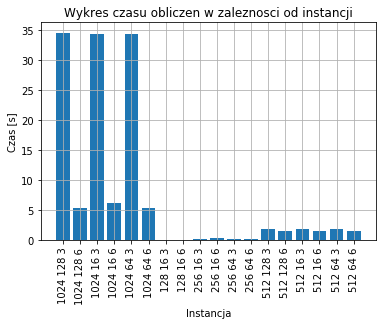

KeyError: 'DTLB L1M L2M'

In [26]:
def plot(measurements, label, title = 'Tytul', xlabel = '[x_label]', ylabel = '[y_label]'):
    #n_groups = 2
    x = [i for i in range(0, len(measurements))]
    data = [(key, measurements[key][label]) for key in measurements]
    data = sorted(data, key=itemgetter(0))
    xticks = [item[0] for item in data]
    y = [item[1] for item in data]
    #y = [measurements[key]['time'] for key in measurements]
    plt.xticks(x, xticks, rotation='vertical')
    plt.bar(x, y)
    plt.grid(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
plot(parallel, 'time', 'Wykres czasu obliczen w zaleznosci od instancji', 'Instancja', 'Czas [s]')
plot(sums, 'DTLB L1M L2M')